# Adaptive Learning with NV Centers - Data Analysis

## Import Modules

In [112]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import qinfer as qi
import models as m
from adaptive import *
from nvdata import *
import scipy.stats as st
import scipy.io as sio
import pandas as pd
from collections import OrderedDict

In [135]:
# Whether to overwrite figures by default while exporting
overwrite = True
# Markers used in line plots
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
marker_list = ['o','v','^','<','>','1','2','3','4','s','p','*','h','H','+']
hatch_list = [None, None, None, None, '/', "\\", r'*', 'o']

### Import Data

In [3]:
rabi_data = sio.loadmat('../data/rabi.mat')['avgData'] * 200 * 50000
rabi_p = (rabi_data[2,:] - rabi_data[1,:]) / (rabi_data[0,:] - rabi_data[1,:])
rabi_p_stds = est_std(rabi_p, rabi_data[0,:], rabi_data[1,:])
rabi_x = np.linspace(0,0.5,rabi_p.size)

ramsey_data = sio.loadmat('../data/ramsey.mat')['avgData'] * 200 * 50000
ramsey_p = (ramsey_data[2,:] - ramsey_data[1,:]) / (ramsey_data[0,:] - ramsey_data[1,:])
ramsey_p_stds = est_std(rabi_p, ramsey_data[0,:], ramsey_data[1,:])
ramsey_x = np.linspace(0, 2, ramsey_p.size)

In [167]:
transfer_function = HeuristicData('../data/transfer_function_new.pkl')
bernoulli_risk = HeuristicData('../data/bernoulli_risk_final.pkl')
full_risk = HeuristicData('../data/full_bayes_risk.pkl')
linear = HeuristicData('../data/alternating_linear_final.pkl')
linear_full = HeuristicData('../data/alternating_linear_ultimate.pkl')
classic_linear = HeuristicData('../data/classic_linear_final.pkl')
power_curve = HeuristicData('../data/power_curve.pkl')
predetermined_tight_prior = HeuristicData('../data/predetermined_with_tight_prior.pkl')
alternating_linear_tight_prior = HeuristicData('../data/alternating_linear_tight_prior.pkl')
full_bayes_tight_prior = HeuristicData('../data/full_bayes_risk_with_tight_prior.pkl')
full_bayes_tight_prior_mag = HeuristicData('../data/full_bayes_risk_with_tight_prior_magnetometry.pkl')
full_bayes_mag = HeuristicData('../data/full_bayes_risk_mag.pkl')

Imported existing Panel with 7 DataFrames from ../data/transfer_function_new.pkl
Imported existing Panel with 100 DataFrames from ../data/bernoulli_risk_final.pkl
Imported existing Panel with 100 DataFrames from ../data/full_bayes_risk.pkl
Imported existing Panel with 139 DataFrames from ../data/alternating_linear_final.pkl
Imported existing Panel with 100 DataFrames from ../data/alternating_linear_ultimate.pkl
Imported existing Panel with 100 DataFrames from ../data/classic_linear_final.pkl
Imported existing Panel with 15 DataFrames from ../data/power_curve.pkl
Imported existing Panel with 100 DataFrames from ../data/predetermined_with_tight_prior.pkl
Imported existing Panel with 100 DataFrames from ../data/alternating_linear_tight_prior.pkl
Imported existing Panel with 100 DataFrames from ../data/full_bayes_risk_with_tight_prior.pkl
Imported existing Panel with 89 DataFrames from ../data/full_bayes_risk_with_tight_prior_magnetometry.pkl
Imported existing Panel with 100 DataFrames fro

Use `OrderedDict` so that things predictably match up with the color, hatching, etc lists defined above.

In [161]:
panels = OrderedDict([
    ('Alternating Linear', linear_full),
    ('Uniformly Weighted Risk', full_risk),
    ('Magnetometry Weighted Risk', full_bayes_mag),
    #('Classic Linear', classic_linear)
])

In [162]:
panels_tight = OrderedDict([
    ('Alternating Linear', alternating_linear_tight_prior),
    ('Uniformly Weighted Risk', full_bayes_tight_prior),
    ('Magnetometry Weighted Risk', full_bayes_tight_prior_mag),
    ('Ramsey Sweeps', predetermined_tight_prior)
])

### Plotting Tools

In [138]:
def make_letter(val,ypos=0.75,axis=None):
    if axis is not None:
        plt.sca(axis)
    plt.gca().text(0.005, ypos, val,
        verticalalignment='bottom', horizontalalignment='left',
        transform=plt.gca().transAxes,
        fontsize=10
    )

def plot_panel_learning(panels, idx_param, param_name=None):
    x_column='cum_eff_num_bits'
    markers = iter(marker_list)
    hatches = iter(hatch_list)
    colors = iter(color_list)
    for name, panel in panels.iteritems():
        print name
        x_vals, y_vals = extract_panel_data(panel, 'smc_cov', idxs=np.s_[idx_param,idx_param], x_column=x_column)
        #x_vals, An_cov = extract_panel_data(panel, 'smc_cov', idxs=np.s_[idx_param,3], x_column=x_column)
        lower, upper, mid = np.percentile(y_vals, [90,10,50], axis=0)
        #plt.semilogy(x_vals, np.mean(y_vals, axis=0), label=name)
        color = next(colors)
        line = plt.semilogy(x_vals+1, mid, '--', markevery=20, marker=next(markers), label=name, color=color)
        plt.fill_between(x_vals+1, lower, upper, alpha=0.2, hatch=next(hatches), edgecolor=color)

    plt.grid()
    if param_name is None:
        model = m.RabiRamseyModel()
        param_name = model.modelparam_names[idx_param]
    plt.ylabel(r'${}$ Posterior Variance (MHz$^2$)'.format(param_name))
    plt.xlabel('Cumulative ESM')
    plt.legend()
    
def plot_panel_eps_histogram(panels, ax_rabi=None, ax_ramsey=None, linear_thresh=None):
    if ax_rabi is None and ax_ramsey is None:
        gs = gridspec.GridSpec(1,2)
        ax_rabi = plt.subplot(gs[0])
        ax_ramsey = plt.subplot(gs[1],sharey=ax_rabi)
        
    hatches = iter(hatch_list)
    colors = iter(color_list)
    for name, panel in panels.iteritems():
        _, eps_array = extract_panel_data(panel, 'expparam', skip_first=True, skip_last=True, idxs=np.s_[0])
        hatch, color = next(hatches), next(colors)
        hatch = 3 * hatch if hatch is not None else None
        if ax_rabi is not None:
            plt.sca(ax_rabi)
            ts = eps_array['t'][eps_array['emode']==m.RabiRamseyModel.RABI]
            plt.hist(ts, bins=np.linspace(0,1,101)+0.0025, alpha=0.5, linewidth=0, label=name, normed=False, weights=np.ones(ts.size)/panel.n_dataframes, hatch=hatch, edgecolor=color)
            plt.xlabel(r'$t_p$ ($\mu$s)')
        
        if ax_ramsey is not None:
            plt.sca(ax_ramsey)
            ts = eps_array['tau'][eps_array['emode']==m.RabiRamseyModel.RAMSEY]
            plt.hist(ts, bins=np.linspace(0,2,101)+0.0025, alpha=0.5, linewidth=0, label=name, normed=False, weights=np.ones(ts.size)/panel.n_dataframes, hatch=hatch, edgecolor=color)
            plt.xlabel(r'$t_w$ ($\mu$s)')
            
    if linear_thresh is not None:
        ticks = range(1,linear_thresh+1) + list(np.linspace(0,100,11)[np.linspace(0,100,11)>linear_thresh+1])
        labeled_ticks = [1,5,10,50]
        for ax in [ax_rabi, ax_ramsey]:
            if ax is not None:
                ax.set_yscale('symlog', linthreshy=linear_thresh)
                ax.set_yticks(ticks)
                ax.yaxis.set_major_formatter(
                    ticker.FuncFormatter(lambda x,_:'{}'.format(int(x)) if x in labeled_ticks else '')
                )
                ax.set_ylim([0,60])
            
def plot_panels(panels):
    gs1 = gridspec.GridSpec(1,1, bottom=0.5)
    ax_learning = plt.subplot(gs1[0])
    plt.sca(ax_learning)
    plot_panel_learning(panels, m.RabiRamseyModel.IDX_ZEEMAN)
    plt.legend(loc=1)
    make_letter('(a)', ypos=0.85)

    plt.xlabel('Cumulative ESM')
    plt.ylabel(r'$\omega_e$ posterior variance (MHz$^2$)')

    gs2 = gridspec.GridSpec(1,2, top=0.3)

    ax_rabi_hist = plt.subplot(gs2[0])
    ax_ramsey_hist = plt.subplot(gs2[1], sharey=ax_rabi_hist)

    plot_panel_eps_histogram(panels, ax_rabi_hist, ax_ramsey_hist, linear_thresh=5)
    ax_rabi_hist.set_ylabel(r'$\langle$# Times Used$\rangle$')
    make_letter('(b) Rabi', ypos=0.83, axis=ax_rabi_hist)
    make_letter('(c) Ramsey', ypos=0.83, axis=ax_ramsey_hist)

    plt.setp(ax_ramsey_hist.get_yticklabels(), visible=False)
    gs1.tight_layout(fig, rect=[None,0.34,None,None], h_pad=0)
    gs2.tight_layout(fig, rect=[None,None,None,0.39], w_pad=0, h_pad=0)

<IPython.core.display.Javascript object>


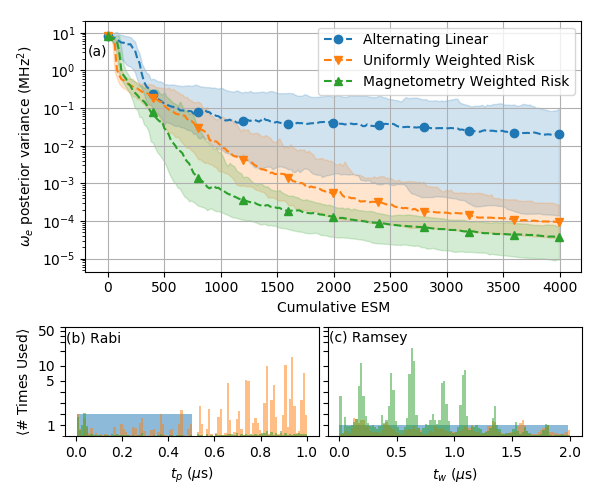

Alternating Linear
Uniformly Weighted Risk
Magnetometry Weighted Risk


In [169]:
fig = plt.figure(figsize=(6,5))
plot_panels(panels)

<IPython.core.display.Javascript object>


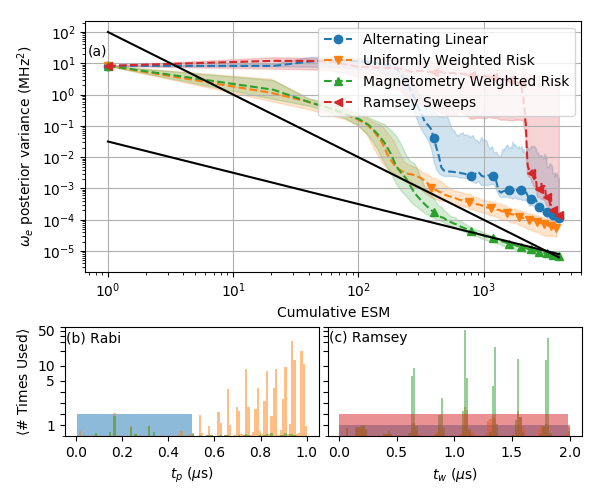

Alternating Linear
Uniformly Weighted Risk
Magnetometry Weighted Risk
Ramsey Sweeps


In [172]:
fig = plt.figure(figsize=(6,5))
plot_panels(panels_tight)

In [173]:
plt.gcf().axes[0].set_xscale('log')
plt.sca(plt.gcf().axes[0])
plt.plot(range(1,4000),(10.**-1.5)*(np.arange(1,4000,dtype=float)**-1),color='k')

In [174]:
plt.plot(range(1,4000),(10.**2)*(np.arange(1,4000,dtype=float)**-2),color='k')

<IPython.core.display.Javascript object>


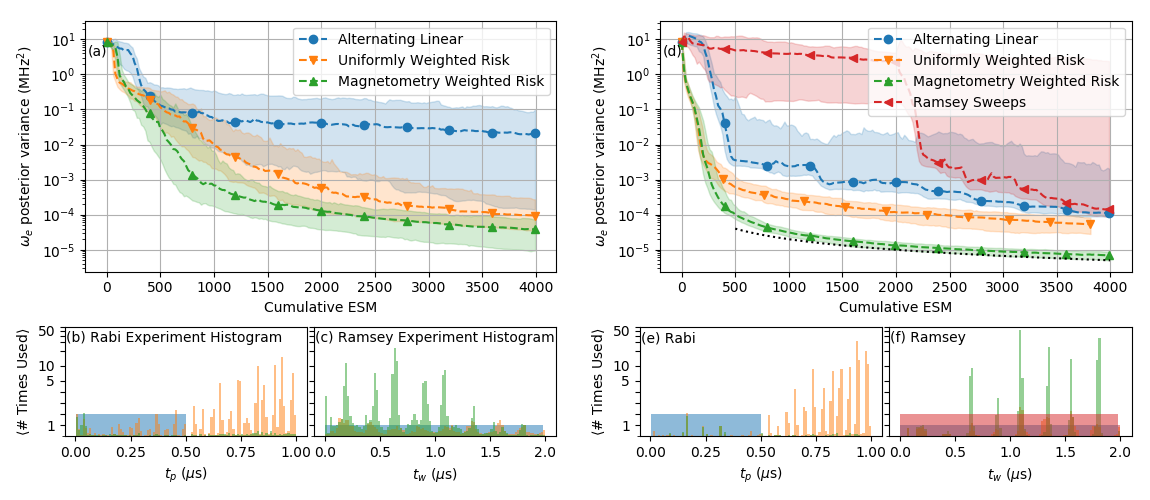

Alternating Linear
Uniformly Weighted Risk
Magnetometry Weighted Risk
Alternating Linear
Uniformly Weighted Risk
Magnetometry Weighted Risk
Ramsey Sweeps
Overwriting ../fig/heuristic-comparison.png
Overwriting ../fig/heuristic-comparison.pdf


In [184]:
fig = plt.figure(figsize=(11.5,5))

### LEFT

gs1 = gridspec.GridSpec(1,1, bottom=0.5, right=0.45)
ax_learning = plt.subplot(gs1[0])
plt.sca(ax_learning)
plot_panel_learning(panels, m.RabiRamseyModel.IDX_ZEEMAN)
plt.legend(loc=1)
make_letter('(a)', ypos=0.85)

plt.xlabel('Cumulative ESM')
plt.ylabel(r'$\omega_e$ posterior variance (MHz$^2$)')

gs2 = gridspec.GridSpec(1,2, top=0.3, right=0.45)

ax_rabi_hist = plt.subplot(gs2[0])
ax_ramsey_hist = plt.subplot(gs2[1], sharey=ax_rabi_hist)

plot_panel_eps_histogram(panels, ax_rabi_hist, ax_ramsey_hist, linear_thresh=5)
ax_rabi_hist.set_ylabel(r'$\langle$# Times Used$\rangle$')
make_letter('(b) Rabi Experiment Histogram', ypos=0.83, axis=ax_rabi_hist)
make_letter('(c) Ramsey Experiment Histogram', ypos=0.83, axis=ax_ramsey_hist)

plt.setp(ax_ramsey_hist.get_yticklabels(), visible=False)

### RIGHT

gs3 = gridspec.GridSpec(1,1, bottom=0.5, left=0.55)
ax_learning = plt.subplot(gs3[0], sharey=ax_learning)
plt.sca(ax_learning)
plot_panel_learning(panels_tight, m.RabiRamseyModel.IDX_ZEEMAN)
plt.plot(range(500,4000),(10.**-1.7)*(np.arange(500,4000,dtype=float)**-1),color='k',ls=':')
plt.legend(loc=1)
make_letter('(d)', ypos=0.85)

plt.xlabel('Cumulative ESM')
plt.ylabel(r'$\omega_e$ posterior variance (MHz$^2$)')

gs4 = gridspec.GridSpec(1,2, top=0.3, left=0.55)

ax_rabi_hist = plt.subplot(gs4[0])
ax_ramsey_hist = plt.subplot(gs4[1], sharey=ax_rabi_hist)

plot_panel_eps_histogram(panels_tight, ax_rabi_hist, ax_ramsey_hist, linear_thresh=5)
ax_rabi_hist.set_ylabel(r'$\langle$# Times Used$\rangle$')
make_letter('(e) Rabi', ypos=0.83, axis=ax_rabi_hist)
make_letter('(f) Ramsey', ypos=0.83, axis=ax_ramsey_hist)

plt.setp(ax_ramsey_hist.get_yticklabels(), visible=False)

gs1.tight_layout(fig, rect=[0,0.34,0.5,1], h_pad=0)
gs2.tight_layout(fig, rect=[0,0,0.5,0.39], w_pad=0, h_pad=0)
gs3.tight_layout(fig, rect=[0.5,0.34,1,1], h_pad=0)
gs4.tight_layout(fig, rect=[0.5,0,1,0.39], w_pad=0, h_pad=0)

export_figure(fig, 'heuristic-comparison')

### Power Curve

<IPython.core.display.Javascript object>


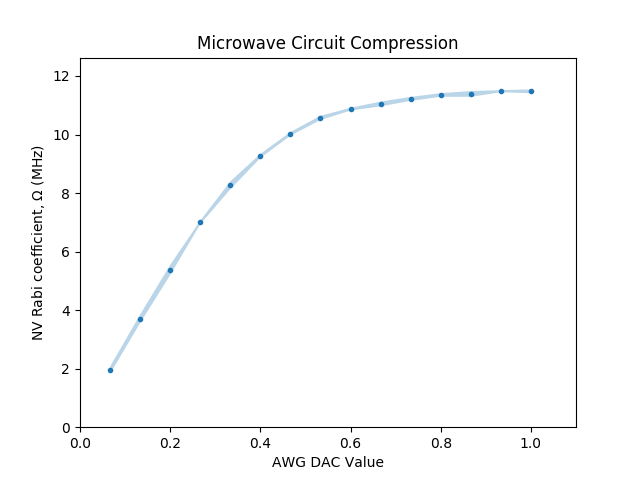

In [25]:
linear_powers = np.empty(power_curve.n_dataframes)
power_curve_ests = np.empty((power_curve.n_dataframes, 5))
power_curve_stds = np.empty((power_curve.n_dataframes, 5))
for idx_df in range(power_curve.n_dataframes):
    df = power_curve.panel[idx_df]
    linear_powers[idx_df] = 10 ** (np.array(list(df.heuristic_value))[-1] / 20)
    power_curve_ests[idx_df, :] = np.array(list(df.smc_mean))[-1,:5]
    power_curve_stds[idx_df, :] = np.sqrt(np.diag(np.array(list(df.smc_cov))[-1,:5,:5]))

plt.figure()
idx_param = 0
plt.plot(linear_powers, power_curve_ests[:,idx_param],'.')
plt.fill_between(
    linear_powers, 
    power_curve_ests[:,idx_param] - 3*power_curve_stds[:,idx_param], 
    power_curve_ests[:,idx_param] + 3*power_curve_stds[:,idx_param],
    alpha=0.3
)
plt.ylim([0, 1.1*np.amax(power_curve_ests[:,idx_param])])
plt.xlim([0, 1.1*np.amax(linear_powers)])

plt.title('Microwave Circuit Compression')
plt.xlabel('AWG DAC Value')
plt.ylabel('NV Rabi coefficient, $\Omega$ (MHz)')

In [161]:
offsets = []
for idx_df in range(transfer_function.n_dataframes):
    df = transfer_function.panel[idx_df]
    offsets.append(df.expparam[1]['wo'])
offsets = np.array(offsets).flatten()
n_offsets = offsets.size

transfer_function_ests = np.empty((n_offsets, 5))
transfer_function_stds = np.empty((n_offsets, 5))
for idx_df in range(transfer_function.n_dataframes):
    df = transfer_function.panel[idx_df]
    transfer_function_ests[idx_df, :] = df.smc_mean[200][:5]
    transfer_function_stds[idx_df, :] = np.sqrt(np.diag(df.smc_cov[200][:5,:5]))

In [86]:
tf_data = np.array([
    [
        list(new_linear.panel[idx_df][label][1:] )
        for idx_df in range(new_linear.n_dataframes)
    ] for label in ['bright', 'dark', 'signal']
]).transpose(1,2,0)

<IPython.core.display.Javascript object>


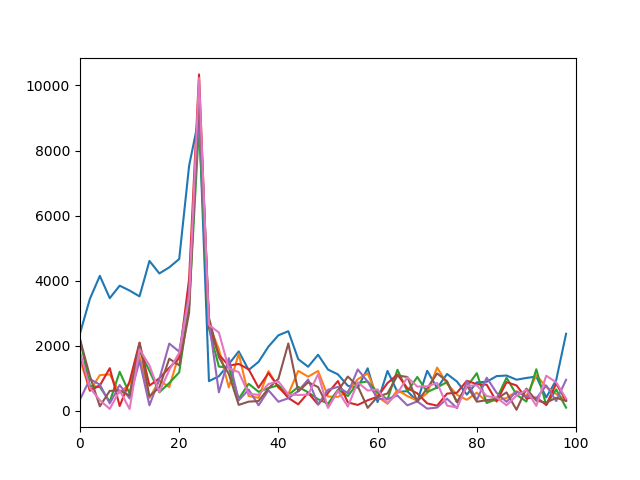

(0, 100)

In [83]:
fig = plt.figure()
for idx in range(7):
    plt.plot(
        np.fft.fftshift(np.fft.fftfreq(tf_data.shape[1]//2, 0.5/100)),
        np.abs(np.fft.fftshift(np.fft.fft(tf_data[idx,::2,2]-np.mean(tf_data[idx,:,2]))))
    )
plt.xlim([0,100])

<IPython.core.display.Javascript object>


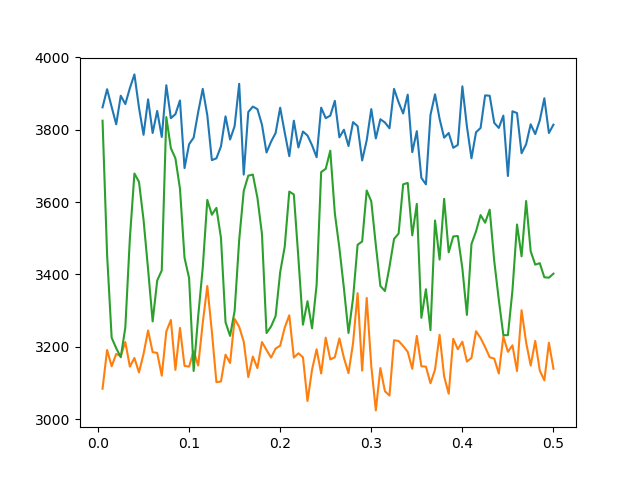

In [162]:
fig = plt.figure()
plt.plot(rabi_x[1:], tf_data[0,::2,0])
plt.plot(rabi_x[1:], tf_data[0,::2,1])
plt.plot(rabi_x[1:], tf_data[0,::2,2])

<IPython.core.display.Javascript object>


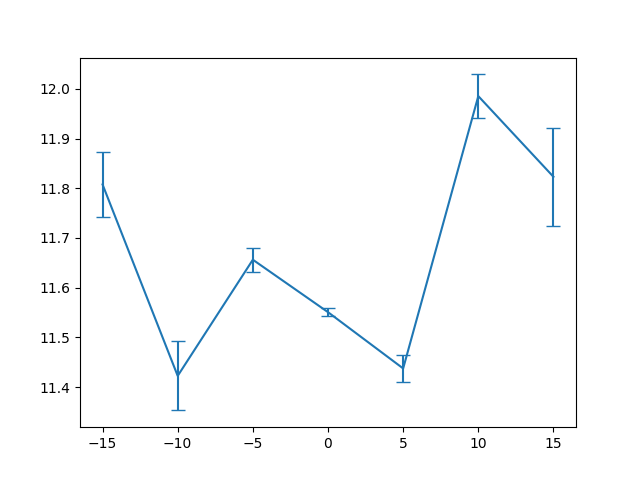

<Container object of 3 artists>

In [163]:
plt.figure()
plt.errorbar(offsets, transfer_function_ests[:,0], yerr=transfer_function_stds[:,0], capsize=5)

<IPython.core.display.Javascript object>


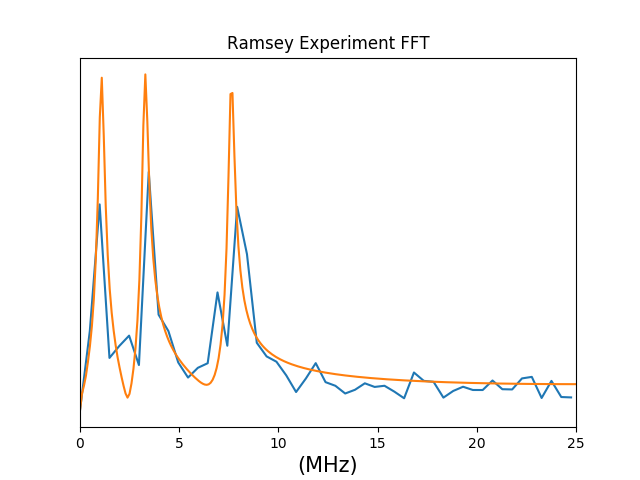

In [49]:
df = linear.panel[10]

fig = plt.figure()

freqs = np.fft.fftshift(np.fft.fftfreq(ramsey_x.size, ramsey_x[1]-ramsey_x[0]))
ramsey_fft = np.fft.fftshift(np.fft.fft(ramsey_p-np.mean(ramsey_p)))
plt.plot(freqs, np.abs(ramsey_fft))

modelparams = list(df.smc_mean)[-1][:5]
freqs, sim_fft = simulate_ramsey_fft(modelparams, max_tau=10,n=501,tp=0.022)
plt.plot(freqs, np.abs(sim_fft))

plt.xlim([0,25])
plt.xlabel(r'(MHz)', size=15)
plt.yticks([])
plt.title('Ramsey Experiment FFT')

In [66]:
new_linear = HeuristicData('../data/alternating_linear_final.pkl')
linear = HeuristicData('../data/alternating_linear_final.pkl.bak')

Created empty Panel.
Imported existing Panel with 43 DataFrames from ../data/alternating_linear_final.pkl.bak


In [68]:
new_linear.save()

In [1]:
linear._df_dict[0].update(
    DataFrame({'eff_num_bits':new_esm,'cum_eff_num_bits':np.cumsum(new_esm)})
)

NameError: name 'linear' is not defined

<IPython.core.display.Javascript object>


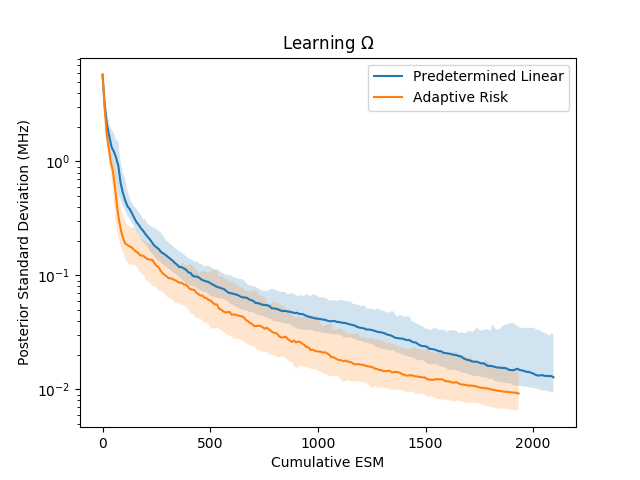

Predetermined Linear
Adaptive Risk


In [185]:
idx_param = m.RabiRamseyModel.IDX_OMEGA
x_column='cum_eff_num_bits'

fig = plt.figure()

for name, panel in panels.iteritems():
    print name
    x_vals, y_vals = extract_panel_data(panel, 'smc_cov', idxs=np.s_[idx_param,idx_param], x_column=x_column)
    lower, upper, mid = np.percentile(y_vals, [90,10,50], axis=0)
    plt.fill_between(x_vals, np.sqrt(lower), np.sqrt(upper), alpha=0.2)
    plt.semilogy(x_vals, np.sqrt(mid), label=name)


plt.ylabel(r'Posterior Standard Deviation (MHz)')
plt.xlabel('Cumulative ESM')
plt.title('Learning ${}$'.format(m.RabiRamseyModel().modelparam_names[idx_param]))
plt.legend()

<IPython.core.display.Javascript object>


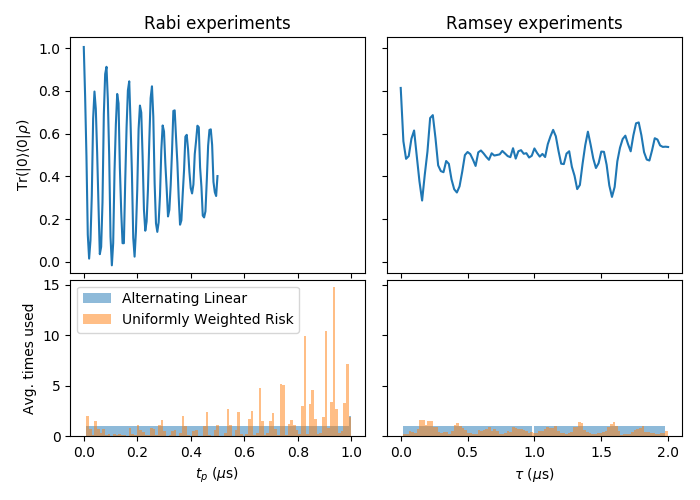

In [359]:
fig = plt.figure(figsize=(7,5))
gs = gridspec.GridSpec(2,2,height_ratios=[1.5,1])

ax_rabi_hist = plt.subplot(gs[1,0])
for name, panel in panels.iteritems():
    _, eps_array = extract_panel_data(panel,'expparam',skip_first=True,idxs=np.s_[0])
    ts = eps_array['t'][eps_array['emode']==m.RabiRamseyModel.RABI]
    plt.hist(ts, bins=100, alpha=0.5, label=name, normed=False, weights=np.ones(ts.size)/panel.n_dataframes)
plt.xlabel(r'$t_p$ ($\mu$s)')
plt.ylabel(r'Avg. times used')
plt.legend()

ax_rabi = plt.subplot(gs[0,0], sharex=ax_rabi_hist)
plt.plot(rabi_x, rabi_p)
plt.title('Rabi experiments')
plt.ylabel(r'Tr$(|0\rangle\langle 0|\rho)$')
plt.ylim([-0.05,1.05])


ax_ramsey_hist = plt.subplot(gs[1,1], sharey=ax_rabi_hist)
for name, panel in panels.iteritems():
    _, eps_array = extract_panel_data(panel,'expparam',skip_first=True,idxs=np.s_[0])
    ts = eps_array['tau'][eps_array['emode']==m.RabiRamseyModel.RAMSEY]
    plt.hist(ts, bins=100, alpha=0.5, label=name, normed=False, weights=np.ones(ts.size)/panel.n_dataframes)
plt.xlabel(r'$\tau$ ($\mu$s)')

ax_ramsey = plt.subplot(gs[0,1], sharex=ax_ramsey_hist, sharey=ax_rabi)
plt.plot(ramsey_x, ramsey_p)
plt.title('Ramsey experiments')
plt.ylim([-0.05,1.05])


plt.setp(ax_ramsey.get_xticklabels(), visible=False)
plt.setp(ax_ramsey.get_yticklabels(), visible=False)
plt.setp(ax_rabi.get_xticklabels(), visible=False)
plt.setp(ax_ramsey_hist.get_yticklabels(), visible=False)

gs.tight_layout(fig,h_pad=0)

<IPython.core.display.Javascript object>


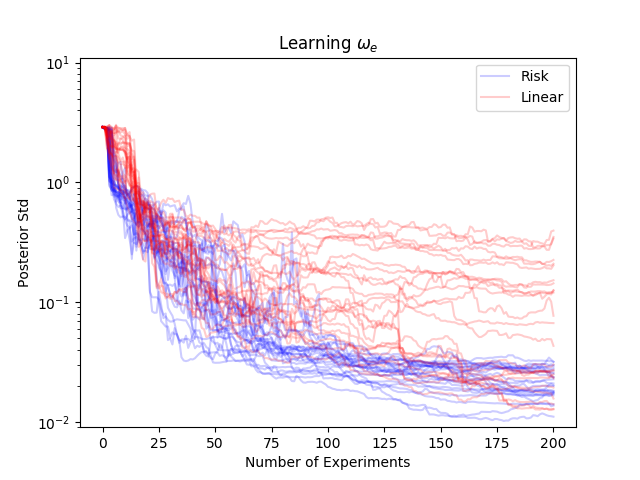

In [37]:
fig =plt.figure()
idx_param = m.RabiRamseyModel.IDX_ZEEMAN
ham_model = m.RabiRamseyModel()

for idx_df in range(bernoulli_risk.n_dataframes):
    df = bernoulli_risk.panel[idx_df]
    label = 'Risk' if idx_df== 0 else None
    plt.semilogy(np.sqrt(np.array(list(df.smc_cov))[:,idx_param,idx_param]), color='b',label=label,alpha=0.2)
    
for idx_df in range(linear.n_dataframes):
    df = linear.panel[idx_df]
    label = 'Linear' if idx_df== 0 else None
    plt.semilogy(np.sqrt(np.array(list(df.smc_cov))[:,idx_param,idx_param]),'r',label=label, alpha=0.2)
    
plt.xlabel('Number of Experiments')
plt.ylabel('Posterior Std')
plt.ylim([0.9*10**-2,1.1*10])
plt.title('Learning ${}$'.format(ham_model.modelparam_names[idx_param]))
plt.legend()

Imported existing Panel with 24 DataFrames from ../data/bernoulli_risk.pkl


<IPython.core.display.Javascript object>


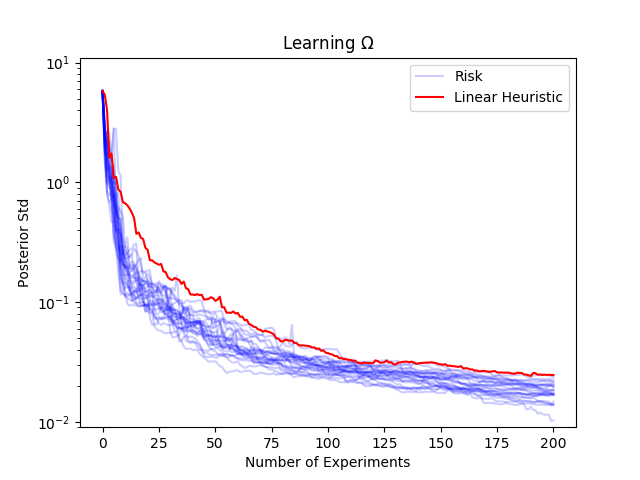

Imported existing Panel with 2 DataFrames from ../data/linear_heuristic_9.pkl


In [4]:
panel_bernoulli_risk = HeuristicData('../data/bernoulli_risk.pkl')
fig =plt.figure()
idx_param = m.RabiRamseyModel.IDX_OMEGA
ham_model = m.RabiRamseyModel()

for idx_df in range(panel_bernoulli_risk.n_dataframes):
    df = panel_bernoulli_risk.panel[idx_df]
    label = 'Risk' if idx_df== 0 else None
    plt.semilogy(np.sqrt(np.array(list(df.smc_cov))[:,idx_param,idx_param]), color='b',label=label,alpha=0.2)
    
panel_linear = HeuristicData('../data/linear_heuristic_9.pkl')
for idx_df in range(1,panel_linear.n_dataframes):
    df = panel_linear.panel[idx_df]
    plt.semilogy(np.sqrt(np.array(list(df.smc_cov))[:,idx_param,idx_param]),'r',label='Linear Heuristic')
    
plt.xlabel('Number of Experiments')
plt.ylabel('Posterior Std')
plt.ylim([0.9*10**-2,1.1*10])
plt.title('Learning ${}$'.format(ham_model.modelparam_names[idx_param]))
plt.legend()

<IPython.core.display.Javascript object>


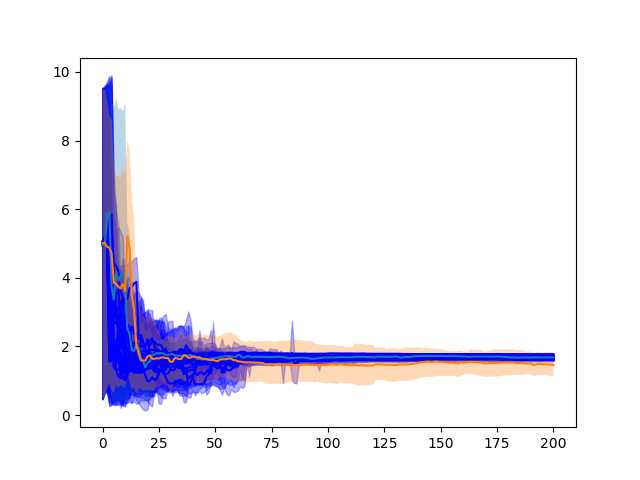

In [9]:
fig = plt.figure()
idx_param = m.RabiRamseyModel.IDX_ZEEMAN
for idx_df in range(panel_bernoulli_risk.n_dataframes):
    df = panel_bernoulli_risk.panel[idx_df]
    plt.plot(np.array(list(df.smc_mean))[:,idx_param], color='b')
    plt.fill_between(
        np.arange(201),
        np.array(list(df.smc_lower_quantile))[:,idx_param],
        np.array(list(df.smc_upper_quantile))[:,idx_param],
        alpha=0.3,
        color='b'
    )
    
for idx_df in range(panel_linear.n_dataframes):
    df = panel_linear.panel[idx_df]
    plt.plot(np.array(list(df.smc_mean))[:,idx_param])
    plt.fill_between(
        np.arange(201),
        np.array(list(df.smc_lower_quantile))[:,idx_param],
        np.array(list(df.smc_upper_quantile))[:,idx_param],
        alpha=0.3
    )

In [24]:
def bat(x, *args, **kwargs):
    pass

In [17]:
df=full_risk.panel[50]

<IPython.core.display.Javascript object>


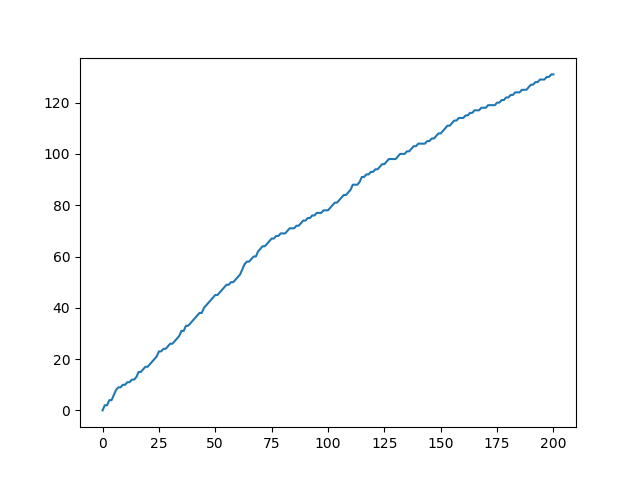

In [22]:
plt.figure()
plt.plot(df.smc_resample_count)

In [16]:
np.prod(np.diag(list(full_risk.panel[50].smc_cov)[-1])[:5])

1.3309621125271516e-16

<IPython.core.display.Javascript object>


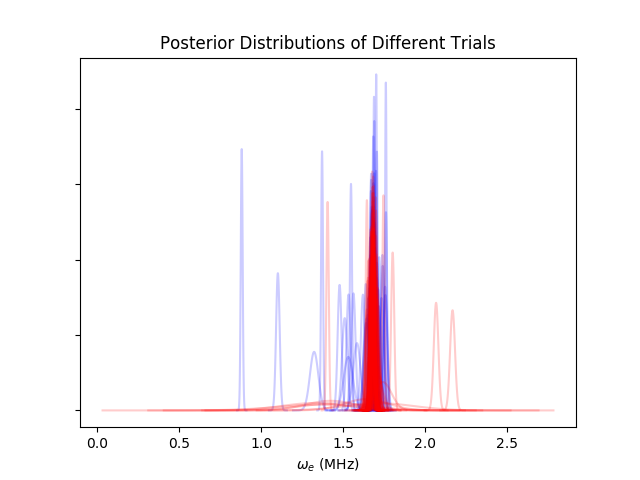

[]

In [6]:
fig = plt.figure()
panel = full_risk
idx_param = 1
for idx_trial in range(panel.n_dataframes):
    mean = np.array(list(panel.panel[idx_trial].smc_mean))[-1,idx_param]
    std = np.sqrt(np.array(list(panel.panel[idx_trial].smc_cov))[-1,idx_param,idx_param])
    x_vals = np.linspace(mean-5*std, mean+5*std, 100)
    plt.plot(x_vals, st.norm.pdf(x_vals, mean, std), alpha=0.2, color='b')
    
panel = classic_linear
idx_param = 1
for idx_trial in range(panel.n_dataframes):
    mean = np.array(list(panel.panel[idx_trial].smc_mean))[-1,idx_param]
    std = np.sqrt(np.array(list(panel.panel[idx_trial].smc_cov))[-1,idx_param,idx_param])
    x_vals = np.linspace(mean-5*std, mean+5*std, 100)
    plt.plot(x_vals, st.norm.pdf(x_vals, mean, std), alpha=0.2, color='r')
    
plt.title('Posterior Distributions of Different Trials')
plt.xlabel('${}$ (MHz)'.format(m.RabiRamseyModel().modelparam_names[idx_param]))
plt.gca().set_yticklabels([])

In [ ]:
import structured

<IPython.core.display.Javascript object>


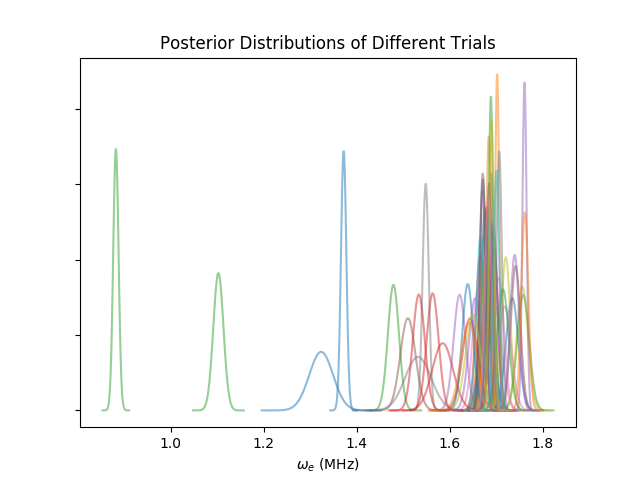

[]

In [18]:
fig = plt.figure()
panel = full_risk
idx_param = 1
for idx_trial in range(1,65):#65,panel.n_dataframes):
    mean = np.array(list(panel.panel[idx_trial].smc_mean))[-1,idx_param]
    std = np.sqrt(np.array(list(panel.panel[idx_trial].smc_cov))[-1,idx_param,idx_param])
    x_vals = np.linspace(mean-5*std, mean+5*std, 100)
    plt.plot(x_vals, st.norm.pdf(x_vals, mean, std), alpha=0.5)
    
plt.title('Posterior Distributions of Different Trials')
plt.xlabel('${}$ (MHz)'.format(m.RabiRamseyModel().modelparam_names[idx_param]))
plt.gca().set_yticklabels([])

In [206]:
df = linear.panel[0]
df = linear.panel[21]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [255]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(colorsys.rgb_to_hls(*mc.to_rgb(c)))
    return colorsys.hls_to_rgb(c[0],1-amount * (1-c[1]),c[2])

<IPython.core.display.Javascript object>


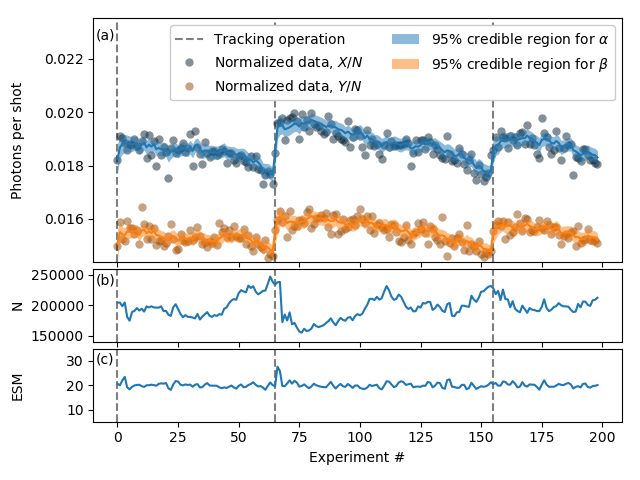

Overwriting ../fig/tracking-example.png
Overwriting ../fig/tracking-example.pdf


In [348]:
fig = plt.figure()
gs = gridspec.GridSpec(3,1,height_ratios=[1,0.3,0.3])

df = linear.panel[21]
esm = np.array(list(df.eff_num_bits)[1:-1])
n_meas = np.array(list(df.expparam)[1:-1])['n_meas'].flatten()
bright = np.array(list(df.bright)[1:-1]) / n_meas
dark = np.array(list(df.dark)[1:-1]) / n_meas

means = np.array(list(df.smc_mean)[1:-1])
alpha = means[:,5]
beta = means[:,6]

std_mult = 2
covs = np.array(list(df.smc_cov)[1:-1])
alpha_std = std_mult * np.sqrt(covs[:,5,5])
beta_std = std_mult * np.sqrt(covs[:,6,6])

def plot_tracks():
    track_locs = np.arange(alpha.size+1)[np.diff(np.nan_to_num(np.array(list(df.preceded_by_tracking)),0)) == 1]
    for idx_loc, loc in enumerate(track_locs):
        label = 'Tracking operation' if idx_loc==0 else None
        plt.axvline(loc, color='k', ls='--', zorder=0, alpha=0.5, label=label)

plt.subplot(gs[1])
plt.plot(n_meas)
plot_tracks()
make_letter('(b)')
plt.gca().set_xticklabels([])
plt.ylabel('N')
plt.ylim([140000,260000])
plt.gca().get_yaxis().set_label_coords(-0.13,0.5)
plt.gca().ticklabel_format(axis='y',style='sci')

plt.subplot(gs[2])
plt.plot(esm)
plot_tracks()
make_letter('(c)')
plt.yticks([10,20,30])
plt.ylim([5,35])
plt.ylabel('ESM')
plt.gca().get_yaxis().set_label_coords(-0.13,0.5)
plt.xlabel('Experiment #')

plt.subplot(gs[0])
plt.plot(alpha, color=color_list[0])
plt.plot(bright, 'o', zorder=0, alpha=0.5, markeredgewidth=0, color=lighten_color(color_list[0],1.5), label='Normalized data, $X/N$')
plt.fill_between(np.arange(alpha.size), alpha - alpha_std, alpha + alpha_std, 
                 lw=0, alpha=0.5, color=color_list[0], 
                 label=r'95% credible region for $\alpha$'
            )
plt.plot(beta, color=color_list[1])
plt.plot(dark, 'o', zorder=0, alpha=0.5, markeredgewidth=0, color=lighten_color(color_list[1],1.5), label='Normalized data, $Y/N$')
plt.fill_between(np.arange(alpha.size), 
                 beta - beta_std, beta + beta_std, 
                 lw=0, alpha=0.5, color=color_list[1],
                 label=r'95% credible region for $\beta$'
            )
make_letter('(a)',0.9)

plt.ylabel('Photons per shot')
plt.gca().set_xticklabels([])
plt.gca().get_yaxis().set_label_coords(-0.13,0.5)

plot_tracks()
    
plt.ylim([0.0144, 0.0235])
plt.legend(ncol=2)
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1,3,4]
leg = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=1,ncol=2)
leg.get_frame().set_alpha(1)

gs.tight_layout(fig, h_pad=0)

export_figure(fig, 'tracking-example')